In [1]:
!uv sync
%load_ext autoreload 
%autoreload 2  
# imported functions are re-imported if they are changed

Resolved 154 packages in 5ms
Audited 151 packages in 0.47ms


In [2]:
import pathlib
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import planetary_computer
import pystac_client
import stackstac
from data_exploration.utils import drop_coords_without_dims

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# MODIS Land surface temperature
The product we're using (MOD11A1 / MYD11A1) contains both Aqua and Terra data. These satellites are sun-synchronous, meaning they pass over the same location at the same time each day. To find this time for our bounding box, we can use the [MODIS overpass predictor](https://oceandata.sci.gsfc.nasa.gov/overpass_pred/).

This will be important in matching the satellite images with the station temperature data. 

In [4]:
# http://bboxfinder.com/
bbox_WSEN = 17.896010,-34.484990,19.598891,-33.159334  

# a single year to get an idea of number of missing data
datetime = "2019-01-01/2019-12-31"
# https://planetarycomputer.microsoft.com/dataset/modis-11A1-061
product = "modis-11A1-061"

# perform a simple search for MODIS data
search = catalog.search(
    collections=[product],
    bbox=bbox_WSEN,
    datetime=datetime)

# retrieve the items into a list-type object (FeatureCollection)
items = search.item_collection()
# these items are simply a standard way of storing metadata of geo-spatial data
# It contains lat/lon, datetime, and other metadata + the link to the actual data

In [61]:
def get_view_time(da):

    date = da.start_datetime.astype('datetime64[D]')  # convert to datetime object
    hour = da[:, 2:4].mean(dim=['x', 'y']).round(0).astype('timedelta64[h]')  # get the mean hour of the day
    view_time = drop_coords_without_dims(date + hour).assign_coords(band=["LST_Day_1km", "LST_Night_1km"])  # add the time to the dataset

    return view_time


def stack_time_daynight_bands(da):
    return (da
        .isel(band=[0, 1])  # only keep the LST bands
        .stack(time_band=("time", "band"))  # combine time and band into a single dimension (day and night)
        .drop_vars('time_band')  # remove the time_band coordinate so that we can rename it to time
        .rename(time_band='time')  # rename the time_band to time
        .assign_coords(time=lambda x: x.view_time)  # assign data values to time (view time)
        .transpose('time', 'y', 'x')  # transpose the data to the correct order
        .sortby('time'))  

In [ ]:
# the stackstac library is able to open the data from the links in the items 
# and stack them into a single xarray dataset into the coordinate reference system of choice
da = stackstac.stack(
    items,
    assets=['LST_Day_1km', 'LST_Night_1km', 'Day_view_time', 'Night_view_time', 'Day_view_angl', 'Night_view_angl'],
    bounds_latlon=bbox_WSEN,  # bounding boxes are always in WSEN order
    epsg=4326,  # WGS84 coordinate reference system (lat/lon)
    resolution=0.01,  # 1/100th of a degree is about 1km
).load()

coords = ['platform', 'instruments', 'title', 'eo:cloud_cover', 'epsg', 'raster:bands', 'view_time', 'band', 'x', 'y']
coords_drop = [coord for coord in da.coords if coord not in coords]
da['view_time'] = get_view_time(da)
da = da.drop_vars(coords_drop)

da_lst = stack_time_daynight_bands(da.sel(band=["LST_Day_1km", "LST_Night_1km"]))
da_angl = stack_time_daynight_bands(da.sel(band=["Day_view_angl", "Night_view_angl"]))

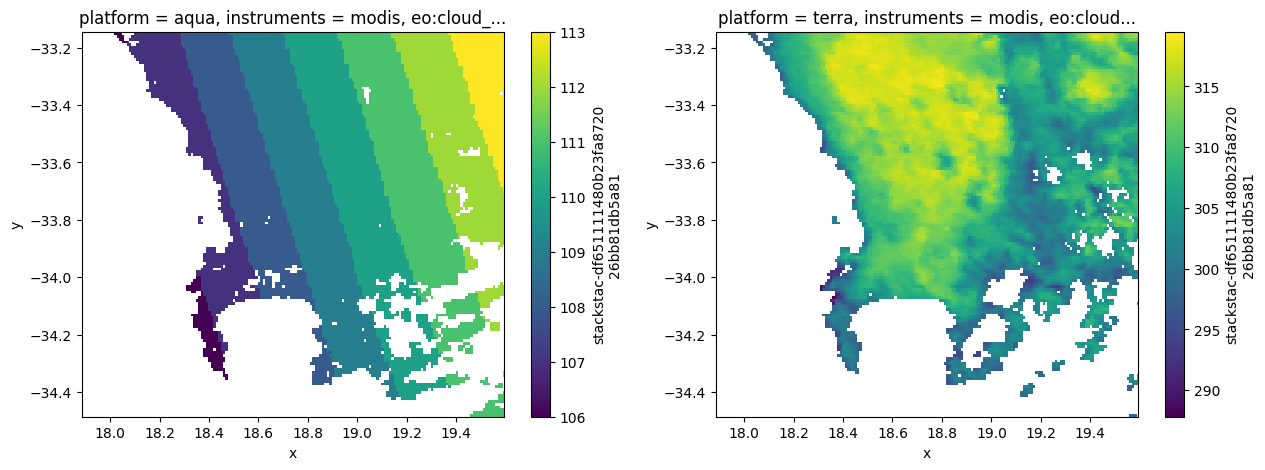

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

t = 55
da_angl[t].plot.imshow(ax=ax[0])
da_lst [t].plot.imshow(ax=ax[1])

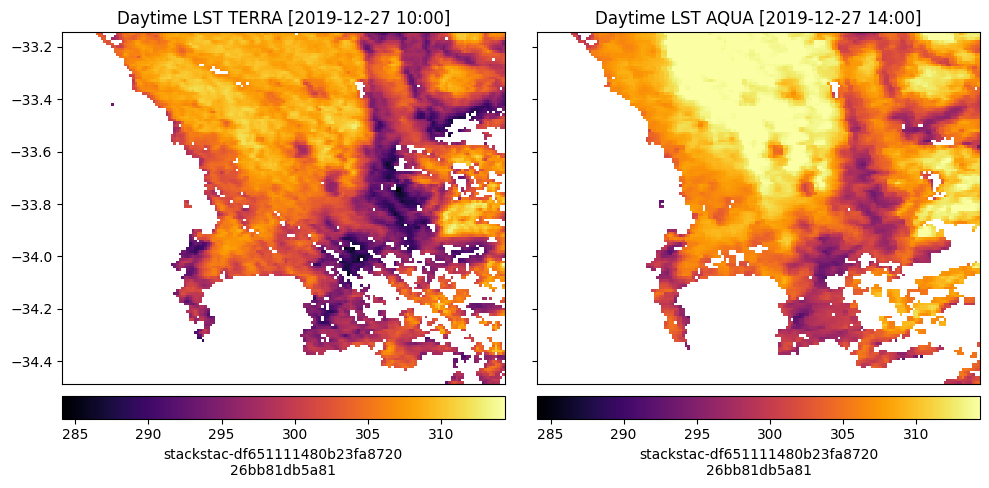

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

da1 = da_lst.isel(time=0, )  # isel = index based selection, here we select the 11th last time step
da2 = da_lst.isel(time=1, )  # we also slect the first band (daytime)

props = dict(cmap='inferno', robust=False, cbar_kwargs=dict(location='bottom', pad=0.03))
img0 = da1.plot.imshow(ax=axs[0], **props)
img1 = da2.plot.imshow(ax=axs[1], **props)

img1.set_clim(img0.get_clim())  # make sure the color limits are the same

[ax.set_xticks([]) for ax in axs]
[ax.set_xlabel('') for ax in axs]
[ax.set_ylabel('') for ax in axs]

axs[0].set_title(f'Daytime LST {da1.platform.item().upper()} [{da1.view_time.dt.strftime("%Y-%m-%d %H:%M").item()}]')
axs[1].set_title(f'Daytime LST {da2.platform.item().upper()} [{da2.view_time.dt.strftime("%Y-%m-%d %H:%M").item()}]')

fig.tight_layout(w_pad=2)

# Cloud cover impact

Here we check how necessary it would actually be to do in-painting since SA is a sunny place 🌞

In [76]:
coverage_pixels = da_lst.count(dim=['x', 'y'])  # how many pixels are there for each time step
total_pixels = coverage_pixels.max(['time']).item()  # the maximum number of pixels at any time step

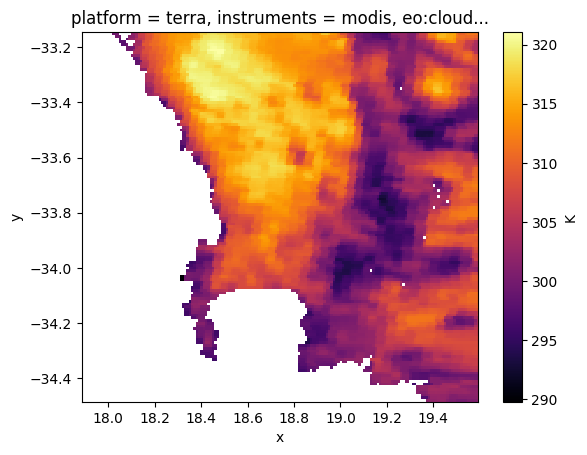

In [79]:
idx_max = coverage_pixels.idxmax('time')
da_lst.sel(time=idx_max).plot.imshow(cmap='inferno', robust=False, cbar_kwargs=dict(label='K'))

In [114]:
drop_coords = [k for k in da_lst.coords.keys() if (str(k).startswith('proj') or str(k).startswith('raster'))]
da_lst.attrs = dict(long_name='Land Surface Temperature', units='K')
ds = da_lst.to_dataset(name='modis_LST').drop(drop_coords)
ds.to_netcdf('modis_LST.nc', encoding={k: {'zlib': 1} for k in ds.data_vars}, engine='h5netcdf')

/var/folders/4n/tkh2q3cn5fl09xv_kq_17v8c0000gn/T/ipykernel_92969/1390675323.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = da_lst.to_dataset(name='modis_LST').drop(drop_coords)


In [172]:
(  # find the mean cloud cover for cloudy days
    (coverage_pixels / total_pixels)  # fraction of time step with data
    .where(lambda x: 
           (x < 0.95)  # filter out cloudless days
           & 
           (x > 0)  # filter out days with no data
        )
    .mean('time')  # average over time
).rename('LST').to_series().round(2)

band
LST_Day_1km      0.50
LST_Night_1km    0.62
Name: LST, dtype: float64

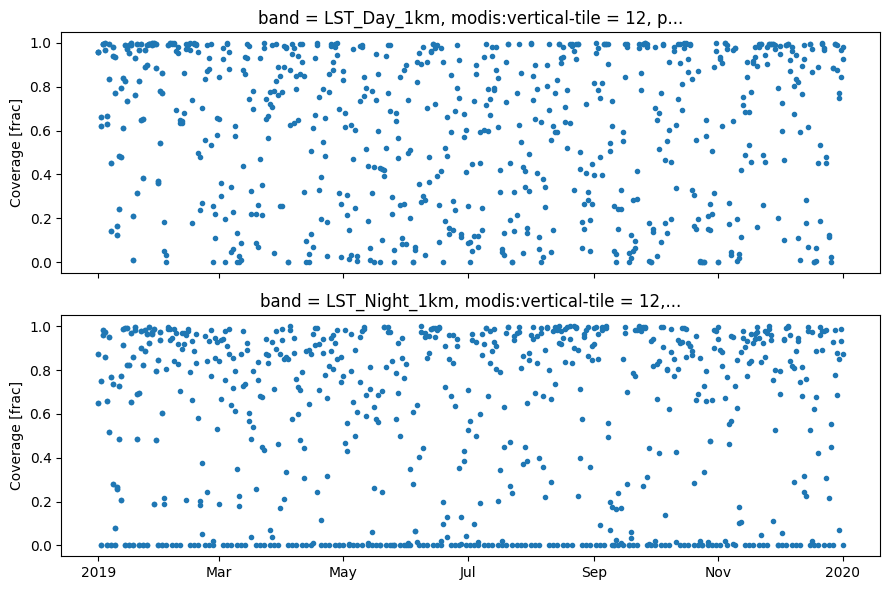

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

da_coverage = coverage_pixels.pipe(lambda x: x / total_pixels)

da_coverage.sel(band='LST_Day_1km').plot(lw=0, marker='.', ax=axs[0])
da_coverage.sel(band='LST_Night_1km').plot(lw=0, marker='.', ax=axs[1])

[ax.set_xlabel('') for ax in axs] 
[ax.set_ylabel('Coverage [frac]') for ax in axs]

fig.tight_layout()